In [2]:
import numpy as np 
from matplotlib import pyplot as plt
from collections import defaultdict
%matplotlib inline

# Privacy analysis for private knn (horizontally distributed dataset)

For now we'll use $k=1$, then we will extend the results for $k > 1$.  
Consider 3 nodes $N_0, N_1, N_2$. We are at round $r=0$.  
Node $N_2$ is the bad guy, he wants to find out the true values of the other two nodes.
With the procedure every nodes puts into $GDV$ their local values, and the procedures finds out the min(max) value for $k$. We are doing k nearest neighbors so we should search for the min value, but that's not really important for our reasonings.  
With $gdv$ we indicate the **global distance vector** which is the vector into which nodes put their local values or randomly generated values, taken from a **local distance vector** $ldv$. $ldv$ is private, while $gdv$ is public.  
At every step of the algorithm a node decides to put a random value into $gdv$ with probability $Pr(r) = p_0 * d^{r - 1}$. The random value is extracted uniformly at random from values in the range $gdv_{i-1},v_i$ where $v_i$ is the value that node $i$ would have put into the global vector and $gdv_{i-1}$ is the global vector passed by the previous node in the ring.

**Values are taken from a real run from the algorithm**  
**We use int values for simplicity. In reality distances are real values. We will see that it's quite difficult in that case**


In [2]:
# From node 0 to node 1
gdv = [13]
ldv = [23]
stack = [23, 13]
contrib = np.setdiff1d(ldv, gdv)
m = len(contrib)
print('contribution of node 1 to current top 1',m, 'with value', ldv[0])
gdv = [22]
# From node 1 to node 2
ldv = [31]
stack = [31, 22]
contrib = np.setdiff1d(ldv, gdv)
m = len(contrib)
print('contribution of node 2 to current top 1', m, 'with value', ldv[0])
gdv = 30

contribution of node 1 to current top 1 1 with value 23
contribution of node 2 to current top 1 1 with value 31


Node 2 wants to know what are the local values of node 1 after the first round. Since $Pr$ is very high after the first round node 2 knows that gdv is probably generated at random. Node 2 receives gdv  = [22].  
We can compute how it is probable that a certain quantity in $gdv$ is the max value $v_{max}$.  
$$P(gdv(r) = v_{max}) = 1 - \prod_{j=1}^{r}Pr(r) = 1 - \prod_{j=1}^{r}{p_0*d^{j-1}}$$
We put $p_0$ out
$$1 - p_0^r * \prod_{j=1}^{r} d^{j - 1}$$
The probability that gdv at a certain round is the max value is $$P(gdv(r) = v_{max}) \geq 1 - p_0^r * d^{\frac{r(r-1)}{2}}$$

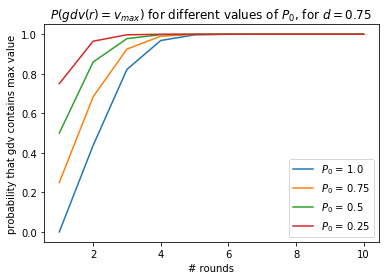

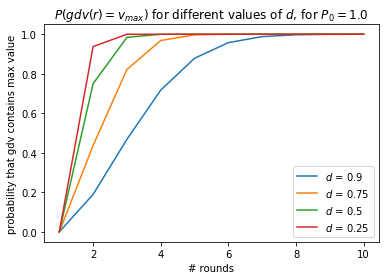

In [5]:
p0 = 1.0
d = 0.75
rounds = 10
all_probs = {}
probs = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[p0] = probs

p0 = 0.75
probs  = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[p0] = probs

p0 = 0.5
probs  = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[p0] = probs

p0 = 0.25
probs  = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[p0] = probs


for p in all_probs:
    prob = all_probs[p]
    plt.plot(list(range(1, rounds+1)), prob, label=r'$P_0$ = ' + str(p))
    plt.xlabel('# rounds')
    plt.ylabel('probability that gdv contains max value')
    plt.legend()

plt.title(r'$P(gdv(r) = v_{max})$ for different values of $P_0$, for $d=0.75$')
plt.savefig('change_p0.png')
plt.show()

p0 = 1.0
d = 0.9
rounds = 10
all_probs = {}
probs = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[d] = probs

d = 0.75
probs = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[d] = probs

d = 0.5
probs = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[d] = probs

d = 0.25
probs  = [1 - (p0**r * d**(r*(r-1))) for r in range(1, rounds+1)]
all_probs[d] = probs


for p in all_probs:
    prob = all_probs[p]
    plt.plot(list(range(1, rounds+1)), prob, label=r'$d$ = ' + str(p))
    plt.xlabel('# rounds')
    plt.ylabel('probability that gdv contains max value')
    plt.legend()

plt.title(r'$P(gdv(r) = v_{max})$ for different values of $d$, for $P_0=1.0$')
plt.savefig('change_d.png')
plt.show()



Let's see a practical example  
Node 2 wants to find out what is the real value of node 1  
Node 1 passes to node 2 $gdv = 19$, which is a uniformly and randomnly generated attribute between the previous $gdv = 27$ and its local value $ldv_1 = 11$. Node 2 decides to act in the following way in order to narrow the range of possible values for the local value of node 1.  
Node 2 passes $gdv = 19$ to node 0 without applying the procedure, node 1 does the same (it has a value that is higher than $gdv$). Now we are in round 1, and when $gdv = 19$ is passed to node 1, it changes its value, since $gdv > ldv_1 = 11$. We have now $gdv = 15$. 
At round 2, with $p0 = 1.0$ and $d = 0.25$ node 2 know that node 1 will drop its value with probability $ 1- Pr = 0.75$. Node 2 cannot be sure the value will be the local one (it really is).  
Now $gdv = 11$, so node 2 knows that at least $ldv < gdv$. If we interrupt the procedure at this round node 2 can just infer the value for the local value of node 1.  
The value for $gdv$ is extracted with probability $Pr$ uniformly at random: For what node 2 knows, 11 is the higher bound for the uniform probability, but it cannot estimate the lower bound. Surely it will be a value higher than 0 since we are talking about distances in this particular domain, but it can't do any ulterior analysis. We have that the boundaries are between 1 and 11. The probability to find the right (int) value is 
$$\frac{1}{\texttt{higher bound} - \texttt{lower bound}} = \frac{1}{11 - 1} = \frac{1}{10}$$. 

Given the uniform probability $$p(x) = \frac{1}{b - a}$$ we can compute the cumulative distributed function $$P(X \leq x) = \frac{x -a}{b - a}$$, where $x$ is a value in the range [a,b).  


We have expressed what is the probability that given the boundary $[a, b)$, the random variable $X$ (i.e. the value extracted uniformly at random for $gdv$, will be less than $x$.  